# 实战 Kaggle 比赛：鐵達尼號

原始資料集：  
train_dataset :(891,12)  
test_dataset :(418,11)  
保留待預測生存欄位：   
X = train_dataset.append(test_dataset):(1309,12)  
y = train_dataset.Survived:(891,)  
合併SibSp及Parch成Family  
X['Family'] = X['SibSp'] + X['Parch']  
X.drop('SibSp', 1, inplace=True) 
X.drop('Parch', 1, inplace=True)  
X:(1309,11)  
刪除Name,Ticket:  
#先去除較無意義的非數值資料 name ticket  
del X['Name'],X['Ticket']  
刪除待預測欄位：  
del X['Survived']  
X:(1309,8)  
X_train=X.head(891)#要把之前合併處理的資料搬出來，訓練與測試集數目才會一樣  
y_train=X_train.PassengerId  
del X_train['PassengerId']  
X_train:(891,7)  
y_train:之前跟X合併整理的418個欄位
y_train:418  
y_test=test_dataset['PassengerId']   
y_test:(418,)

## 0.引入所需模組與必要的資料集

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

from scipy import stats



warnings.filterwarnings('ignore')
sns.set_style('whitegrid')

%matplotlib inline
train_dataset = pd.read_csv('../../data/kaggle_titanic/train.csv')
test_dataset = pd.read_csv('../../data/kaggle_titanic/test.csv')

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import learning_curve

## 1.查看資料
1.形態、架構   
info()：資料長寬，型態，各型態個數    
describe():數值資料的分佈  
describe(include=['O']):O代表object查看非數值資料  
isnull()：看資料缺值個數  
 


In [7]:
print("---training_data---")
train_dataset.info()
print("---testing_data---")
test_dataset.info()

---training_data---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
---testing_data---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null o

In [8]:
print("---training_data---")
train_dataset.describe()
print("---testing_data---")
test_dataset.describe()

---training_data---
---testing_data---


,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


In [9]:
print("---training_data---")
train_dataset.describe(include=['O'])
print("---testing_data---")
test_dataset.describe(include=['O'])

---training_data---
---testing_data---


,Name,Sex,Ticket,Cabin,Embarked
count,418,418,418,91,418
unique,418,2,363,76,3
top,"Dennis, Mr. William",male,PC 17608,B57 B59 B63 B66,S
freq,1,266,5,3,270


有用：  
survival:是否存活[0,1]，預測目標  
pclass:船票等級[1,2,3]  
sex:性別  
age:年齡  
sibsp:平輩數目sibling兄弟,spouses夫妻   
#Spouse =husband, wife (mistresses情婦 and fiancés未婚夫 were ignored)   
parch:長晚輩數目parent,children  
ticket:船票編號
fare:票價
cabin:船艙號碼  
embarked:登陸港口[c,q,s] 

用處不大：  
passengerId:乘客Id，應該都是unique 
name:姓名  

Text(0.5, 1.0, 'train feature corr')

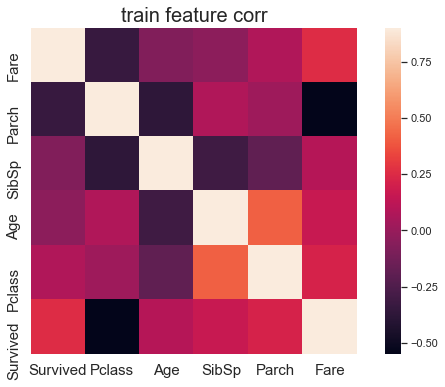

In [8]:
sns.set(context="paper", font="monospace")
sns.set(style="white")
f, ax = plt.subplots(figsize=(10,6))
train_corr = train_dataset.drop('PassengerId',axis=1).corr()
sns.heatmap(train_corr, ax=ax, vmax=.9, square=True)
ax.set_xticklabels(train_corr.index, size=15)
ax.set_yticklabels(train_corr.columns[::-1], size=15)
ax.set_title('train feature corr', fontsize=20)

正相關：  
1.票價跟獲救  
2.父母小孩數跟階級  
3.兄弟姊妹跟年齡  
負相關；  
1.階級跟獲救  
2.父母小孩數跟票價   

In [16]:
print('----train dataset column types information-------')
dtype_df = train_dataset.dtypes.reset_index()
dtype_df.columns = ["Count", "Column Type"]
dtype_df.groupby("Column Type").aggregate('count').reset_index()

----train dataset column types information-------


,Column Type,Count
0,int64,5
1,float64,2
2,object,5


## 2.分析資料
1.處理訓練與測試集是否重疊    
2.是否有重複值  
3.是否有缺失值  
4.查看各資料跟生存關係，生存欄位只有在訓練集，分析完再做之後處理   
5.分析姓名稱呼與存活關係  
6.分析船票與存活關係  

In [11]:
print('Id is unique.') if train_dataset.PassengerId.nunique() == train_dataset.shape[0] else print('oops')
print('Train and test sets are distinct.') if len(np.intersect1d(train_dataset.PassengerId.values, test_dataset.PassengerId.values))== 0 else print('oops')#0表示train,test dataset資料一致
#查看資料是否有nan並設置datasetHasNan flag   
datasetHasNan = False
if train_dataset.count().min() == train_dataset.shape[0] and test_dataset.count().min() == test_dataset.shape[0] :
    print('We do not need to worry about missing values.') 
else:
    datasetHasNan = True
    print('oops we have nan')


Id is unique.
Train and test sets are distinct.
oops we have nan


In [12]:
#Check for missing data & list them 
if datasetHasNan == True:
    nas = pd.concat([train_dataset.isnull().sum(), test_dataset.isnull().sum()], axis=1, keys=['Train Dataset', 'Test Dataset']) 
    print('Nan in the data sets')
    print(nas[nas.sum(axis=1) > 0])

Nan in the data sets
          Train Dataset  Test Dataset
Age                 177          86.0
Cabin               687         327.0
Embarked              2           0.0
Fare                  0           1.0


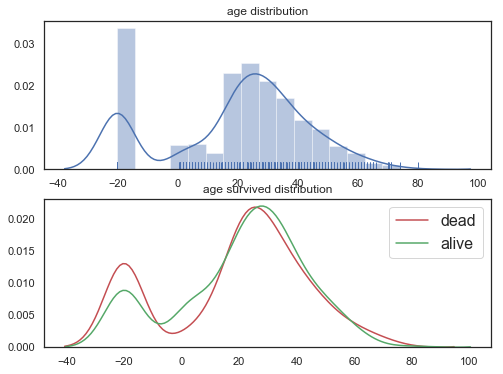

In [12]:
#年齡跟生存率關係  
fig, axes = plt.subplots(2,1,figsize=(8,6))
sns.set_style('white')
sns.distplot(train_dataset.Age.fillna(-20), rug=True, color='b', ax=axes[0])
ax0 = axes[0]
ax0.set_title('age distribution')
ax0.set_xlabel('')

ax1 = axes[1]
ax1.set_title('age survived distribution')
k1 = sns.distplot(train_dataset[train_dataset.Survived==0], hist=False, color='r', ax=ax1, label='dead')
k2 = sns.distplot(train_dataset[train_dataset.Survived==1], hist=False, color='g', ax=ax1, label='alive')
ax1.set_xlabel('')
ax1.legend(fontsize=16)


1.不論是否獲救age分佈都很寬    
2.age跟survived不是線性關係，要用離散處理      
3.獲救的人age缺值更少  

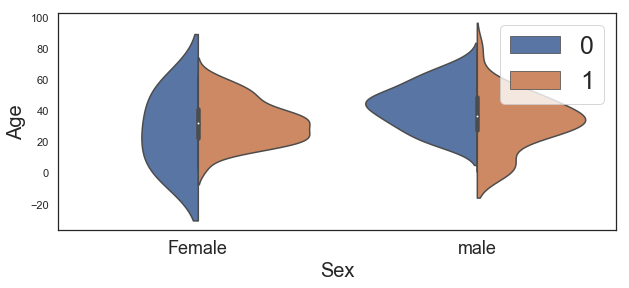

In [11]:
#年齡跟生存率關係  
ax = plt.figure(figsize=(10,4)).add_subplot(111)
sns.violinplot(x='Sex', y='Age', hue='Survived', data=train_dataset.dropna(), split=True)
ax.set_xlabel('Sex',size=20)
ax.set_xticklabels(['Female','male'], size=18)
ax.set_ylabel('Age',size=20)
ax.legend(fontsize=25,loc='best')


0:死亡 1:獲救   
1.女性獲救集中在20-40歲  
2.男性小孩也容易獲救  

In [13]:
# Class vs Survived，存活率高到低，P1,P2,P3  
print(train_dataset[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean().sort_values(by='Survived', ascending=False))
print()
# Sex vs Survived
print(train_dataset[["Sex", "Survived"]].groupby(['Sex'], as_index=False).mean().sort_values(by='Survived', ascending=False))
print()
# Class and Sex vs Survived
print(train_dataset[['Pclass', 'Sex', 'Survived']].groupby(['Pclass', 'Sex'], as_index=False).mean().sort_values(by='Survived', ascending=False))
print()
# SibSp vs Survived
print(train_dataset[["SibSp", "Survived"]].groupby(['SibSp'], as_index=False).mean().sort_values(by='Survived', ascending=False))
print()
# Family vs Survived
train_dataset['Family'] = train_dataset['SibSp'] + train_dataset['Parch']
print(train_dataset[['Family', 'Survived']].groupby(['Family'], as_index=False).mean().sort_values(by='Survived', ascending=False))
print()
# Embark vs Survived
print(train_dataset[['Embarked', 'Survived']].groupby(['Embarked'], as_index=False).mean().sort_values(by='Survived', ascending=False))
print()

   Pclass  Survived
0       1  0.629630
1       2  0.472826
2       3  0.242363

      Sex  Survived
0  female  0.742038
1    male  0.188908

   Pclass     Sex  Survived
0       1  female  0.968085
2       2  female  0.921053
4       3  female  0.500000
1       1    male  0.368852
3       2    male  0.157407
5       3    male  0.135447

   SibSp  Survived
1      1  0.535885
2      2  0.464286
0      0  0.345395
3      3  0.250000
4      4  0.166667
5      5  0.000000
6      8  0.000000

   Family  Survived
3       3  0.724138
2       2  0.578431
1       1  0.552795
6       6  0.333333
0       0  0.303538
4       4  0.200000
5       5  0.136364
7       7  0.000000
8      10  0.000000

  Embarked  Survived
0        C  0.553571
1        Q  0.389610
2        S  0.336957



In [78]:
train_dataset['Name']

0                                Braund, Mr. Owen Harris
1      Cumings, Mrs. John Bradley (Florence Briggs Th...
2                                 Heikkinen, Miss. Laina
3           Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                               Allen, Mr. William Henry
5                                       Moran, Mr. James
6                                McCarthy, Mr. Timothy J
7                         Palsson, Master. Gosta Leonard
8      Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)
9                    Nasser, Mrs. Nicholas (Adele Achem)
10                       Sandstrom, Miss. Marguerite Rut
11                              Bonnell, Miss. Elizabeth
12                        Saundercock, Mr. William Henry
13                           Andersson, Mr. Anders Johan
14                  Vestrom, Miss. Hulda Amanda Adolfina
15                      Hewlett, Mrs. (Mary D Kingcome) 
16                                  Rice, Master. Eugene
17                          Wil

In [82]:
for title in ["Mr.", "Sir.", "Dr.", "Major.", "Master."]:
    num = train_dataset[(train_dataset["Name"].str.contains(title))]["Name"].count()
    age = train_dataset[(train_dataset["Name"].str.contains(title))]["Age"].mean()
    print("{} –> {} males, Age average is {}".format(title, num, age))
print("————————————————————-")
for title in ["Ms.", "Miss.", "Mrs.", "Lady."]:
    num = train_dataset[(train_dataset["Name"].str.contains(title))]["Name"].count()
    age = train_dataset[(train_dataset["Name"].str.contains(title))]["Age"].mean()
    print("{} –> {} females, Age average is {}".format(title, num, age))

Mr. –> 647 males, Age average is 33.11839530332681
Sir. –> 3 males, Age average is 35.5
Dr. –> 11 males, Age average is 39.44444444444444
Major. –> 2 males, Age average is 48.5
Master. –> 40 males, Age average is 4.574166666666667
————————————————————-
Ms. –> 1 females, Age average is 28.0
Miss. –> 182 females, Age average is 21.773972602739725
Mrs. –> 129 females, Age average is 35.642857142857146
Lady. –> 1 females, Age average is 48.0


In [89]:
for title in ["Mr.", "Sir.", "Dr.", "Major.", "Master."]:
    num_survived = train_dataset[(train_dataset['Survived']==1) & (train_dataset['Name'].str.contains(title))]["Name"].count()
    num_died = train_dataset[(train_dataset['Survived']==0) & (train_dataset['Name'].str.contains(title))]["Name"].count()
    print("{} total:{} –> {} survived, {} died. {}% survived".format(title, num_survived+num_died, num_survived, num_died, (100*num_survived/(num_survived+num_died))))
print("————————————————————-")

for title in ["Ms.", "Miss.", "Mrs.", "Lady."]:
    num_survived = train_dataset[(train_dataset['Survived']==1) & (train_dataset['Name'].str.contains(title))]["Name"].count()
    num_died = train_dataset[(train_dataset['Survived']==0) & (train_dataset['Name'].str.contains(title))]["Name"].count()  
    print("{} total:{} –> {} survived, {} died. {}% survived".format(title, num_survived+num_died, num_survived, num_died, (100*num_survived/(num_survived+num_died))))

Mr. total:647 –> 184 survived, 463 died. 28.438948995363216% survived
Sir. total:3 –> 1 survived, 2 died. 33.333333333333336% survived
Dr. total:11 –> 6 survived, 5 died. 54.54545454545455% survived
Major. total:2 –> 1 survived, 1 died. 50.0% survived
Master. total:40 –> 23 survived, 17 died. 57.5% survived
————————————————————-
Ms. total:1 –> 1 survived, 0 died. 100.0% survived
Miss. total:182 –> 127 survived, 55 died. 69.78021978021978% survived
Mrs. total:129 –> 102 survived, 27 died. 79.06976744186046% survived
Lady. total:1 –> 1 survived, 0 died. 100.0% survived


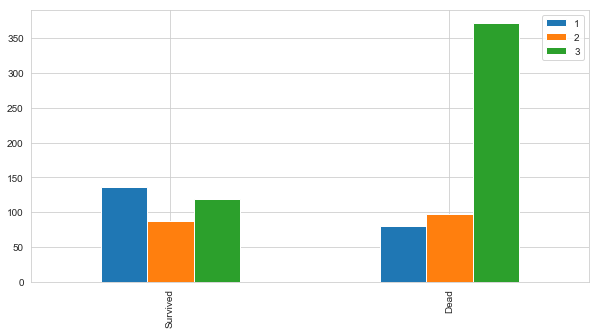

In [95]:
#階級與生存關係
survived_pclass = train_dataset[train_dataset['Survived']==1]['Pclass'].value_counts()
dead_pclass = train_dataset[train_dataset['Survived']==0]['Pclass'].value_counts()
df = pd.DataFrame([survived_pclass,dead_pclass])
df.index = ['Survived','Dead']
df.plot(kind='bar',stacked=False, figsize=(10,5))

Text(0.5, 1.0, 'Pclass Surveved count')

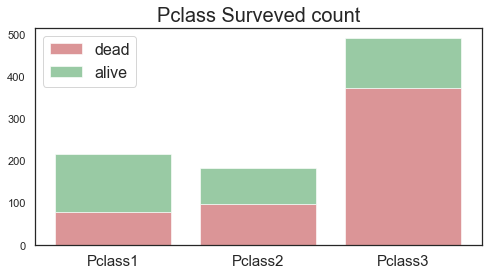

In [17]:
#階級跟生存率關係  
y_dead = train_dataset[train_dataset.Survived==0].groupby('Pclass')['Survived'].count()
y_alive = train_dataset[train_dataset.Survived==1].groupby('Pclass')['Survived'].count()
pos = [1, 2, 3]
ax = plt.figure(figsize=(8,4)).add_subplot(111)
ax.bar(pos, y_dead, color='r', alpha=0.6, label='dead')
ax.bar(pos, y_alive, color='g', bottom=y_dead, alpha=0.6, label='alive')
ax.legend(fontsize=16, loc='best')
ax.set_xticks(pos)
ax.set_xticklabels(['Pclass%d'%(i) for i in range(1,4)], size=15)
ax.set_title('Pclass Surveved count', size=20)

階級越高，生存率越大  

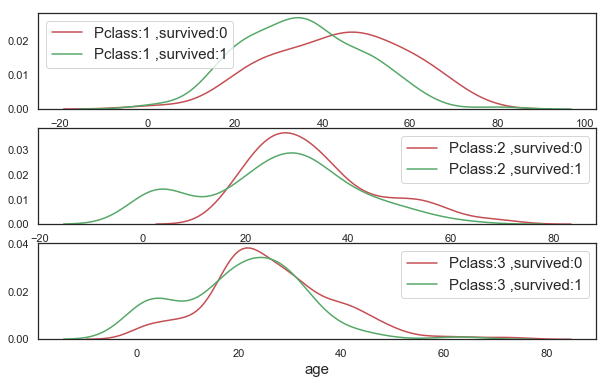

In [18]:
pos = range(0,6)
age_list = []
for Pclass_ in range(1,4):
    for Survived_ in range(0,2):
        age_list.append(train_dataset[(train_dataset.Pclass == Pclass_)&(train_dataset.Survived == Survived_)].Age.values)

fig, axes = plt.subplots(3,1,figsize=(10,6))

i_Pclass = 1
for ax in axes:
    sns.distplot(age_list[i_Pclass*2-2], hist=False, ax=ax, label='Pclass:%d ,survived:0'%(i_Pclass), color='r')
    sns.distplot(age_list[i_Pclass*2-1], hist=False, ax=ax, label='Pclass:%d ,survived:1'%(i_Pclass), color='g')
    i_Pclass += 1
    ax.set_xlabel('age', size=15)
    ax.legend(fontsize=15)

1.頭等艙獲救年齡偏高  
2.其他兩個艙小孩獲救比例比較高  

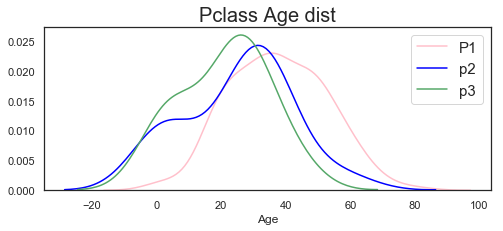

In [21]:
#階級跟年齡關係
f, ax = plt.subplots(figsize=(8,3))
ax.set_title('Pclass Age dist', size=20)
sns.distplot(train_dataset[train_dataset.Pclass==1].dropna().Age, hist=False, color='pink', label='P1')
sns.distplot(train_dataset[train_dataset.Pclass==2].dropna().Age, hist=False, color='blue', label='p2')
sns.distplot(train_dataset[train_dataset.Pclass==3].dropna().Age, hist=False, color='g', label='p3')
ax.legend(fontsize=15)

階級越高年齡越大  

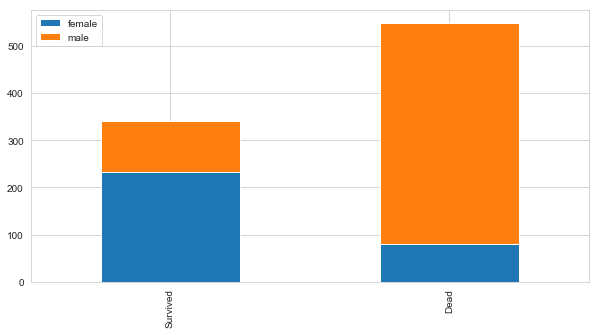

In [97]:
#性別與生存率關係
survived_sex = train_dataset[train_dataset['Survived']==1]['Sex'].value_counts()
dead_sex = train_dataset[train_dataset['Survived']==0]['Sex'].value_counts()
df = pd.DataFrame([survived_sex,dead_sex])
df.index = ['Survived','Dead']
df.plot(kind='bar',stacked=True, figsize=(10,5))

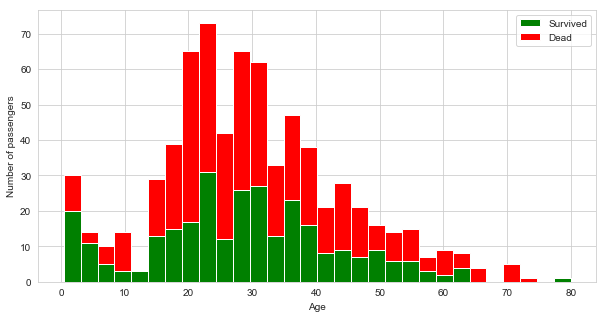

In [96]:
#年齡與生存率關係
figure = plt.figure(figsize=(10,5))
plt.hist([train_dataset[train_dataset['Survived']==1]['Age'], train_dataset[train_dataset['Survived']==0]['Age']], stacked=True, color = ['g','r'],bins = 30,label = ['Survived','Dead'])
plt.xlabel('Age')
plt.ylabel('Number of passengers')
plt.legend()

In [13]:
#填補艙房號碼缺失值nan->-  
train_dataset['Cabin'].fillna('-', inplace=True)
cabinList = ['C', 'E', 'G', 'D', 'A', 'B', 'F','T']
for Cabin in cabinList:
    mask =  (train_dataset['Cabin'].str.contains(Cabin))
    train_dataset.loc[mask,'Cabin'] = Cabin

In [14]:
#艙房號碼Cabin與Pclass關係，艙房等級低缺失值越高  
total_Cabin_p1 = train_dataset[train_dataset['Pclass']==1]['Cabin'].value_counts()
total_Cabin_p2 = train_dataset[train_dataset['Pclass']==2]['Cabin'].value_counts()
total_Cabin_p3 = train_dataset[train_dataset['Pclass']==3]['Cabin'].value_counts()
print("Cabin_p1: \n",total_Cabin_p1,"\n")
print("Cabin_p2: \n",total_Cabin_p2,"\n")
print("Cabin_p3: \n",total_Cabin_p3,"\n")

Cabin_p1: 
 C    59
B    47
-    40
D    29
E    25
A    15
T     1
Name: Cabin, dtype: int64 

Cabin_p2: 
 -    168
F      8
E      4
D      4
Name: Cabin, dtype: int64 

Cabin_p3: 
 -    479
G      7
E      4
F      1
Name: Cabin, dtype: int64 



如果照分佈分配會好點嗎？

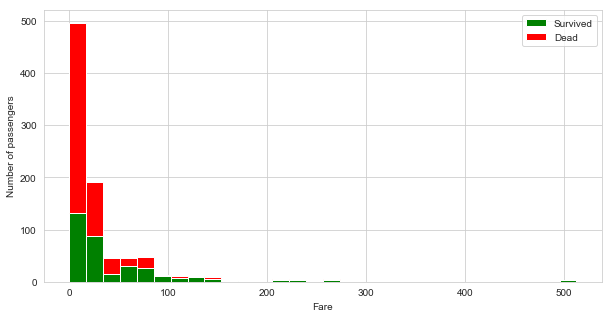

In [118]:
#票價與生存關係，票價低死亡率高
figure = plt.figure(figsize=(10,5))
plt.hist([train_dataset[train_dataset['Survived']==1]['Fare'],train_dataset[train_dataset['Survived']==0]['Fare']], stacked=True, color = ['g','r'],bins = 30,label = ['Survived','Dead'])
plt.xlabel('Fare')
plt.ylabel('Number of passengers')
plt.legend()

Text(0.5, 0, 'Fare')

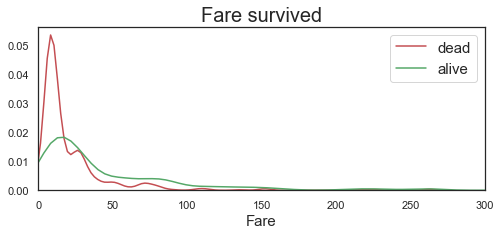

In [26]:
fig = plt.figure(figsize=(8,3))
ax1 = fig.add_subplot(111)
sns.kdeplot(train_dataset[train_dataset.Survived==0].Fare, ax=ax1, label='dead', color='r')
sns.kdeplot(train_dataset[train_dataset.Survived==1].Fare, ax=ax1, label='alive', color='g')
ax1.set_xlim([0,300])
ax1.legend(fontsize=15)
ax1.set_title('Fare survived', size=20)
ax1.set_xlabel('Fare', size=15)

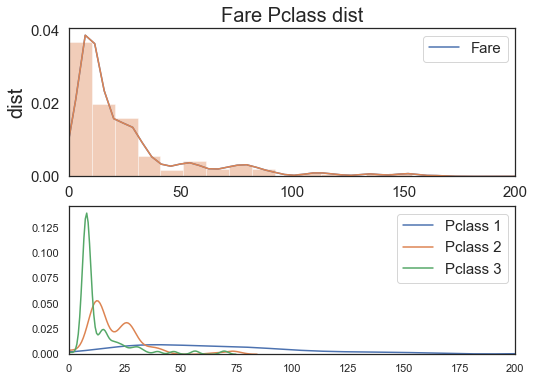

In [25]:
#票價與階級關係  
fig = plt.figure(figsize=(8, 6))
ax = plt.subplot2grid((2,2), (0,0), colspan=2)

ax.tick_params(labelsize=15)
ax.set_title('Fare dist', size=20)
ax.set_ylabel('dist', size=20)
sns.kdeplot(train_dataset.Fare, ax=ax)
sns.distplot(train_dataset.Fare, ax=ax)
ax.legend(fontsize=15)
pos = range(0,400,50)
ax.set_xticks(pos)
ax.set_xlim([0, 200])
ax.set_xlabel('')

ax1 = plt.subplot2grid((2,2), (1,0), colspan=2)
ax.set_title('Fare Pclass dist', size=20)
for i in range(1,4):
    sns.kdeplot(train_dataset[train_dataset.Pclass==i].Fare, ax=ax1, label='Pclass %d'%(i))
ax1.set_xlim([0,200])
ax1.legend(fontsize=15)

票價越高越容易獲救  

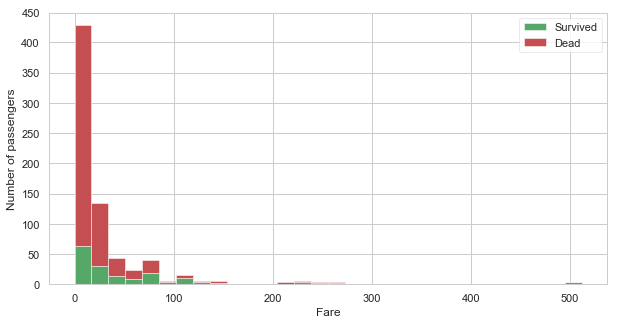

In [45]:
#票價跟港口歸係C
figure = plt.figure(figsize=(10,5))
plt.hist([train_dataset[train_dataset['Embarked']=='C']['Fare'],train_dataset[train_dataset['Survived']==0]['Fare']], stacked=True, color = ['g','r'],bins = 30,label = ['Survived','Dead'])
plt.xlabel('Fare')
plt.ylabel('Number of passengers')
plt.legend()

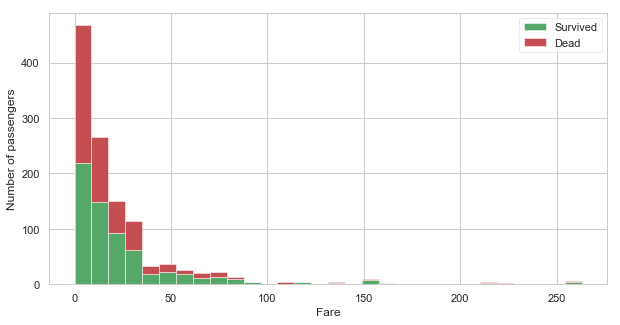

In [46]:
#票價跟港口歸係S
figure = plt.figure(figsize=(10,5))
plt.hist([train_dataset[train_dataset['Embarked']=='S']['Fare'],train_dataset[train_dataset['Survived']==0]['Fare']], stacked=True, color = ['g','r'],bins = 30,label = ['Survived','Dead'])
plt.xlabel('Fare')
plt.ylabel('Number of passengers')
plt.legend()

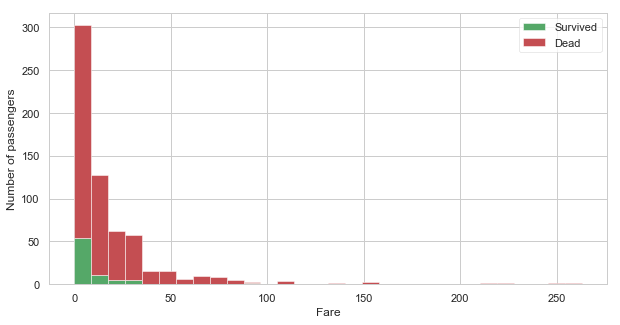

In [47]:
#票價跟港口歸係Q
figure = plt.figure(figsize=(10,5))
plt.hist([train_dataset[train_dataset['Embarked']=='Q']['Fare'],train_dataset[train_dataset['Survived']==0]['Fare']], stacked=True, color = ['g','r'],bins = 30,label = ['Survived','Dead'])
plt.xlabel('Fare')
plt.ylabel('Number of passengers')
plt.legend()

In [117]:
#港口跟階級關係  
total_Pclass_S = train_dataset[train_dataset['Embarked']=='S']['Pclass'].count()
total_Pclass_C = train_dataset[train_dataset['Embarked']=='C']['Pclass'].count()
total_Pclass_Q = train_dataset[train_dataset['Embarked']=='Q']['Pclass'].count()

Embarked_S = train_dataset[train_dataset['Embarked']=='S']['Pclass'].value_counts() / total_Pclass_S
Embarked_C = train_dataset[train_dataset['Embarked']=='C']['Pclass'].value_counts() / total_Pclass_C
Embarked_Q = train_dataset[train_dataset['Embarked']=='Q']['Pclass'].value_counts() / total_Pclass_Q  

df = pd.DataFrame([Embarked_S,Embarked_C,Embarked_Q])
df.index = ['Southampton','Cherbourg','Queenstown']
display(df)

,1,2,3
Southampton,0.197205,0.254658,0.548137
Cherbourg,0.505952,0.101190,0.392857
Queenstown,0.025974,0.038961,0.935065


港口階級關係：  
p1:c  
p2:s  
p3:q  

C上岸的獲救率高  

Text(0.5, 1.0, 'Embarked Age Dist ')

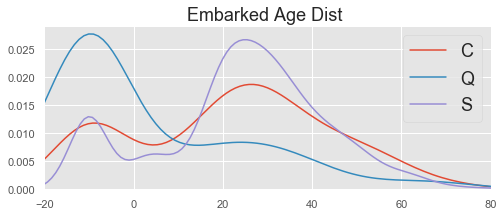

In [29]:
#那個港口年齡層呢
ax = plt.figure(figsize=(8,3)).add_subplot(111)
ax.set_xlim([-20, 80])
sns.kdeplot(train_dataset[train_dataset.Embarked=='C'].Age.fillna(-10), ax=ax, label='C')
sns.kdeplot(train_dataset[train_dataset.Embarked=='Q'].Age.fillna(-10), ax=ax, label='Q')
sns.kdeplot(train_dataset[train_dataset.Embarked=='S'].Age.fillna(-10), ax=ax, label='S')
ax.legend(fontsize=18)
ax.set_title('Embarked Age Dist ', size=18)

1.Q上岸的年紀比較輕  
2.C上岸的小孩老人比例高  

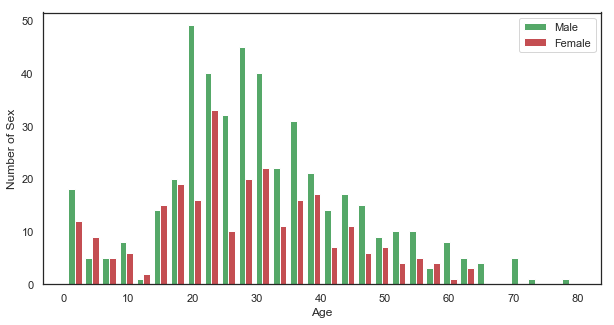

In [13]:
#船上各年齡層男女比例  
figure = plt.figure(figsize=(10,5))
plt.hist([train_dataset[train_dataset['Sex']=='male']['Age'], train_dataset[train_dataset['Sex']=='female']['Age']], stacked=False, color = ['g','r'], bins = 30,label = ['Male','Female'])
plt.xlabel('Age')
plt.ylabel('Number of Sex')
plt.legend()

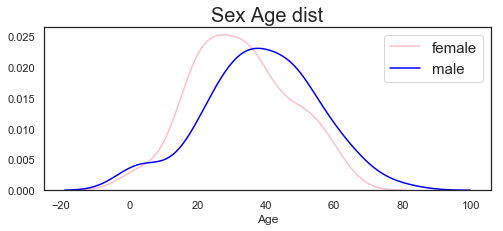

In [14]:
f, ax = plt.subplots(figsize=(8,3))
ax.set_title('Sex Age dist', size=20)
sns.distplot(train_dataset[train_dataset.Sex=='female'].dropna().Age, hist=False, color='pink', label='female')
sns.distplot(train_dataset[train_dataset.Sex=='male'].dropna().Age, hist=False, color='blue', label='male')
ax.legend(fontsize=15)


男性中老年人多，女性更年轻；小孩中男孩较多

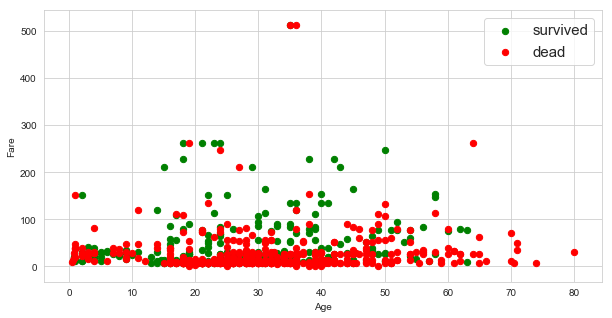

In [102]:
#年齡，票價，存活關係  
plt.figure(figsize=(10,5))
ax = plt.subplot()
ax.scatter(train_dataset[train_dataset['Sex']=='female']['Age'],train_dataset[train_dataset['Sex']=='female']['Fare'],c='green',s=40)
ax.scatter(train_dataset[train_dataset['Sex']=='male']['Age'],train_dataset[train_dataset['Sex']=='male']['Fare'],c='red',s=40)
ax.set_xlabel('Age')
ax.set_ylabel('Fare')
ax.legend(('survived','dead'),scatterpoints=1,loc='upper right',fontsize=15,)

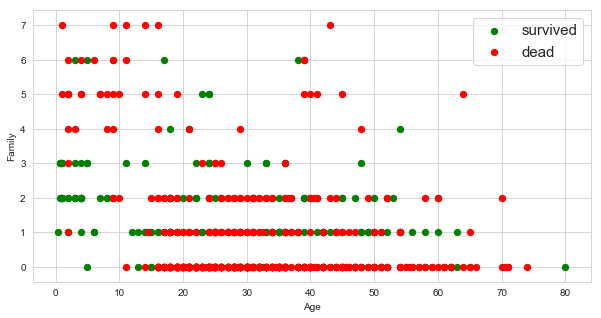

In [106]:
#親屬，年齡，存活關係
plt.figure(figsize=(10,5))
ax = plt.subplot()
ax.scatter(train_dataset[train_dataset['Survived']==1]['Age'],train_dataset[train_dataset['Survived']==1]['Family'],c='green',s=40)
ax.scatter(train_dataset[train_dataset['Survived']==0]['Age'],train_dataset[train_dataset['Survived']==0]['Family'],c='red',s=40)
ax.set_xlabel('Age')
ax.set_ylabel('Family')
ax.legend(('survived','dead'),scatterpoints=1,loc='upper right',fontsize=15,)

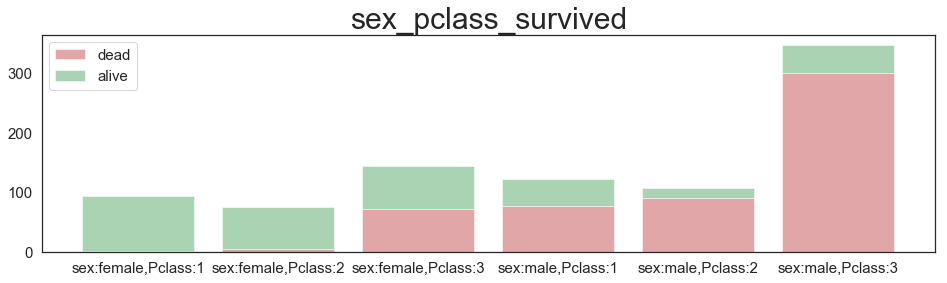

In [24]:
#性別，階級，獲救  
label = []
for sex_i in ['female','male']:
    for pclass_i in range(1,4):
        label.append('sex:%s,Pclass:%d'%(sex_i, pclass_i))
        
pos = range(6)
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(111)
ax.bar(pos, 
        train_dataset[train_dataset['Survived']==0].groupby(['Sex','Pclass'])['Survived'].count().values, 
        color='r', 
        alpha=0.5, 
        align='center',
        tick_label=label, 
        label='dead')
ax.bar(pos, 
        train_dataset[train_dataset['Survived']==1].groupby(['Sex','Pclass'])['Survived'].count().values, 
        bottom=train_dataset[train_dataset['Survived']==0].groupby(['Sex','Pclass'])['Survived'].count().values,
        color='g',
        alpha=0.5,
        align='center',
        tick_label=label, 
        label='alive')
ax.tick_params(labelsize=15)
ax.set_title('sex_pclass_survived', size=30)
ax.legend(fontsize=15,loc='best')

1.綜合來看綠色較多，女性容易獲救   
2.階級越高越容易獲救  

## 3.特徵工程 
1.合併待預測(生存)欄位  
2.合併訓練測試集做資料清理，增加生存相關性較大的新feature      

In [15]:
print ('***********Train*************')
print (train_dataset.isnull().sum())
print ('***********test*************')
print (test_dataset.isnull().sum())

***********Train*************
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin            0
Embarked         2
dtype: int64
***********test*************
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


In [16]:
#保存待預測生存欄位  
y= train_dataset.Survived

#train_dataset.drop('Survived', 1, inplace=True)
X = train_dataset.append(test_dataset)
print(X.shape)
print(y.shape)

(1309, 12)
(891,)


In [17]:
#合併SibSp及Parch成family
X['Family'] = X['SibSp'] + X['Parch']
X.drop('SibSp', 1, inplace=True)
X.drop('Parch', 1, inplace=True)
print(X.shape)

(1309, 11)


In [19]:
X.info()
#從總數Int64Index: 1309-各欄位可以知道缺值狀況  
'''
Age 1309-1046 少263個
Cabin船艙 1039-982 少57個
Fare票價 少1個  
Embarked登陸港口 少2個 
Survived 少418個，測試集都沒有很正常
'''

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 11 columns):
Age            1046 non-null float64
Cabin          982 non-null object
Embarked       1307 non-null object
Family         1309 non-null int64
Fare           1308 non-null float64
Name           1309 non-null object
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Sex            1309 non-null object
Survived       891 non-null float64
Ticket         1309 non-null object
dtypes: float64(3), int64(3), object(5)
memory usage: 122.7+ KB


'\nAge 1309-1046 少263個\nCabin船艙 1039-982 少57個\nFare票價 少1個  \nEmbarked登陸港口 少2個 \nSurvived 少418個，測試集都沒有很正常\n'

### 處理缺值Age

In [53]:
#從稱謂處理缺值Age  
for title in ["Mr.", "Sir.", "Dr.", "Major.", "Master."]:
    num = X[(X['Name'].str.contains(title))]["Name"].count()
    age_mean = round(X[(X['Name'].str.contains(title))]["Age"].mean(),1)
    age_median = X[(X['Name'].str.contains(title))]["Age"].median()
    num_survived = X[(X['Survived']==1) & (X['Name'].str.contains(title))]["Name"].count()
    num_died = X[(X['Survived']==0) & (X['Name'].str.contains(title))]["Name"].count()
    num_total = num_survived+num_died
    print("{} –> {} males, Age average is {}, median is {},  {} survived, {} died. {}% survived".format(title, num, age_mean, age_median, num_survived, num_died, round(num_survived*100/num_total, 1)))
print("——————————————————————————–")
for title in ["Ms.", "Miss.", "Mrs.", "Lady."]:
    num = X[(X['Name'].str.contains(title))]["Name"].count()
    age_mean = round(X[(X['Name'].str.contains(title))]["Age"].mean(), 1)
    age_median = X[(X['Name'].str.contains(title))]["Age"].median()
    num_survived = X[(X['Survived']==1) & (X['Name'].str.contains(title))]["Name"].count()
    num_died = X[(X['Survived']==0) & (X['Name'].str.contains(title))]["Name"].count()
    num_total = num_survived+num_died
    print("{} –> {} females, Age average is {}, median is {},  {} survived, {} died. {}% survived".format(title, num, age_mean, age_median, num_survived, num_died, round(num_survived*100/num_total, 1)))
                                                

Mr. –> 959 males, Age average is 33.3, median is 30.0,  184 survived, 463 died. 28.4% survived
Sir. –> 3 males, Age average is 35.5, median is 35.5,  1 survived, 2 died. 33.3% survived
Dr. –> 17 males, Age average is 37.3, median is 36.0,  6 survived, 5 died. 54.5% survived
Major. –> 2 males, Age average is 48.5, median is 48.5,  1 survived, 1 died. 50.0% survived
Master. –> 61 males, Age average is 5.5, median is 4.0,  23 survived, 17 died. 57.5% survived
——————————————————————————–
Ms. –> 2 females, Age average is 28.0, median is 28.0,  1 survived, 0 died. 100.0% survived
Miss. –> 260 females, Age average is 21.8, median is 22.0,  127 survived, 55 died. 69.8% survived
Mrs. –> 201 females, Age average is 36.8, median is 35.0,  102 survived, 27 died. 79.1% survived
Lady. –> 1 females, Age average is 48.0, median is 48.0,  1 survived, 0 died. 100.0% survived


In [18]:
#缺值全部用median填補  
mask =  (X["Age"].isnull()) & ( (X["Name"].str.contains("Mr.")) | (X["Name"].str.contains("Sir.")) | (X["Name"].str.contains("Major")) )
mask2 =  ( (X["Name"].str.contains("Mr.")) | (X["Name"].str.contains("Sir.")) | (X["Name"].str.contains("Major")) )
X.loc[mask,"Age"] = X.loc[mask,"Age"].fillna(X.loc[mask2,"Age"].median())
print("——————————————————————————–")  
mask =  (X["Age"].isnull()) & ( (X["Name"].str.contains("Ms.")) | (X["Name"].str.contains("Miss.")) )
mask2 = ( (X["Name"].str.contains("Ms.")) | (X["Name"].str.contains("Miss.")) )
X.loc[mask,"Age"] = X.loc[mask,"Age"].fillna(X.loc[mask2,"Age"].median())
print("done")  

——————————————————————————–
done


In [19]:
X.info()
#還少7個

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 11 columns):
Age            1300 non-null float64
Cabin          982 non-null object
Embarked       1307 non-null object
Fare           1308 non-null float64
Name           1309 non-null object
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Sex            1309 non-null object
Survived       891 non-null float64
Ticket         1309 non-null object
Family         1309 non-null int64
dtypes: float64(3), int64(3), object(5)
memory usage: 122.7+ KB


In [20]:
X[X['Age'].isnull()]
#都是master

,Age,Cabin,Embarked,Fare,Name,PassengerId,Pclass,Sex,Survived,Ticket,Family
65,NaN,-,C,15.2458,"Moubarek, Master. Gerios",66,3,male,1.0,2661,2
159,NaN,-,S,69.5500,"Sage, Master. Thomas Henry",160,3,male,0.0,CA. 2343,10
176,NaN,-,S,25.4667,"Lefebre, Master. Henry Forbes",177,3,male,0.0,4133,4
709,NaN,-,C,15.2458,"Moubarek, Master. Halim Gonios (""William George"")",710,3,male,1.0,2661,2
766,NaN,-,C,39.6000,"Brewe, Dr. Arthur Jackson",767,1,male,0.0,112379,0
244,NaN,NaN,S,23.4500,"Johnston, Master. William Arthur Willie""""",1136,3,male,NaN,W./C. 6607,3
339,NaN,NaN,C,7.2292,"Betros, Master. Seman",1231,3,male,NaN,2622,0
344,NaN,NaN,S,14.5000,"van Billiard, Master. James William",1236,3,male,NaN,A/5. 851,2
417,NaN,NaN,C,22.3583,"Peter, Master. Michael J",1309,3,male,NaN,2668,2


In [21]:
#填補age1
mask =  (X['Age'].isnull()) & ( X['Name'].str.contains('Master.') )
X.loc[mask,'Age'] = X.loc[mask,'Age'].fillna(X[X['Name'].str.contains('Master.')]['Age'].median())

In [22]:
X[X['Age'].isnull()]

,Age,Cabin,Embarked,Fare,Name,PassengerId,Pclass,Sex,Survived,Ticket,Family
766,NaN,-,C,39.6,"Brewe, Dr. Arthur Jackson",767,1,male,0.0,112379,0


In [23]:
#填補age2
mask =  (X["Age"].isnull()) & ( X['Name'].str.contains("Dr\.") )
X.loc[mask,'Age'] = X.loc[mask,'Age'].fillna(X[X['Name'].str.contains("Dr\.")]["Age"].median())

### 處理缺值fare  

In [24]:
X[X.Fare.isnull()]

,Age,Cabin,Embarked,Fare,Name,PassengerId,Pclass,Sex,Survived,Ticket,Family
152,60.5,NaN,S,NaN,"Storey, Mr. Thomas",1044,3,male,NaN,3701,0


In [25]:
X['Fare'].fillna(X['Fare'].median(), inplace=True)

In [26]:
#数据中Fare分布太宽，做一下scaling，加速模型收敛
import sklearn.preprocessing as preprocessing
scaler = preprocessing.StandardScaler()
#Fare
fare_scale_param = scaler.fit(X['Fare'].values.reshape(-1, 1))
X.Fare = fare_scale_param.transform(X['Fare'].values.reshape(-1, 1))

### 處理缺值Embarked  

Text(0.5, 1.0, 'Embarked survived count')

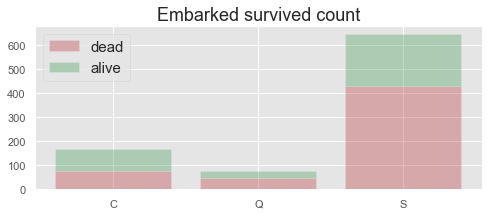

In [28]:
#港口跟獲救關係  
plt.style.use('ggplot')
ax = plt.figure(figsize=(8,3)).add_subplot(111)
pos = [1, 2, 3]
y1 = train_dataset[train_dataset.Survived==0].groupby('Embarked')['Survived'].count().sort_index().values
y2 = train_dataset[train_dataset.Survived==1].groupby('Embarked')['Survived'].count().sort_index().values
ax.bar(pos, y1, color='r', alpha=0.4, align='center', label='dead')
ax.bar(pos, y2, color='g', alpha=0.4, align='center', label='alive', bottom=y1)
ax.set_xticks(pos)
ax.set_xticklabels(['C','Q','S'])
ax.legend(fontsize=15, loc='best')
ax.set_title('Embarked survived count', size=18)

In [27]:
X[X['Embarked'].isnull()]

,Age,Cabin,Embarked,Fare,Name,PassengerId,Pclass,Sex,Survived,Ticket,Family
61,38.0,B,NaN,0.903274,"Icard, Miss. Amelie",62,1,female,1.0,113572,0
829,62.0,B,NaN,0.903274,"Stone, Mrs. George Nelson (Martha Evelyn)",830,1,female,1.0,113572,0


In [28]:
#港口S
print(X.Embarked.value_counts())
print(X[(X.Pclass==0)].Embarked.value_counts())
print(X[(X.Pclass==1)].Embarked.value_counts())
print(X[(X.Pclass==2)].Embarked.value_counts())

S    914
C    270
Q    123
Name: Embarked, dtype: int64
Series([], Name: Embarked, dtype: int64)
S    177
C    141
Q      3
Name: Embarked, dtype: int64
S    242
C     28
Q      7
Name: Embarked, dtype: int64


In [29]:
#S人數最多死亡率也高，遺失的兩人很有可能是Ｓ  
X["Embarked"].fillna("S", inplace=True)

In [30]:
X.describe()
#從count可以知道除了待預測欄位其他數值都沒有缺值了，那非數值呢  

,Age,Fare,PassengerId,Pclass,Survived,Family
count,1309.000000,1.309000e+03,1309.000000,1309.000000,891.000000,1309.000000
mean,29.448946,-7.330101e-17,655.000000,2.294882,0.383838,0.883881
std,13.137353,1.000382e+00,378.020061,0.837836,0.486592,1.583639
min,0.170000,-6.434642e-01,1.000000,1.000000,0.000000,0.000000
25%,22.000000,-4.908050e-01,328.000000,2.000000,0.000000,0.000000
50%,30.000000,-3.640034e-01,655.000000,3.000000,0.000000,0.000000
75%,35.000000,-3.878613e-02,982.000000,3.000000,1.000000,1.000000
max,80.000000,9.262028e+00,1309.000000,3.000000,1.000000,10.000000


In [31]:
X.describe(include=['O'])
#cabin有缺  

,Cabin,Embarked,Name,Sex,Ticket
count,982,1309,1309,1309,1309
unique,83,3,1307,2,929
top,-,S,"Kelly, Mr. James",male,CA. 2343
freq,687,916,2,843,11


In [65]:
X[X['Cabin'].isnull()]

,Age,Cabin,Embarked,Fare,Name,PassengerId,Pclass,Sex,Survived,Ticket,Family
0,34.5,NaN,Q,-0.492093,"Kelly, Mr. James",892,3,male,NaN,330911,0
1,47.0,NaN,S,-0.508125,"Wilkes, Mrs. James (Ellen Needs)",893,3,female,NaN,363272,1
2,62.0,NaN,Q,-0.456164,"Myles, Mr. Thomas Francis",894,2,male,NaN,240276,0
3,27.0,NaN,S,-0.475981,"Wirz, Mr. Albert",895,3,male,NaN,315154,0
4,22.0,NaN,S,-0.405895,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",896,3,female,NaN,3101298,2
5,14.0,NaN,S,-0.465106,"Svensson, Mr. Johan Cervin",897,3,male,NaN,7538,0
6,30.0,NaN,Q,-0.495960,"Connolly, Miss. Kate",898,3,female,NaN,330972,0
7,26.0,NaN,S,-0.082772,"Caldwell, Mr. Albert Francis",899,2,male,NaN,248738,2
8,18.0,NaN,C,-0.503693,"Abrahim, Mrs. Joseph (Sophie Halaut Easu)",900,3,female,NaN,2657,0
9,21.0,NaN,S,-0.176543,"Davies, Mr. John Samuel",901,3,male,NaN,A/4 48871,2


### 處理缺值Cabin   
#之前艙房號碼Cabin與Pclass關係知道 

1.艙房等級低缺失值越多(等級高-p1,p2,p3->等級低)    
2.票價低死亡率高(依三種票價等級選出人數最多的船艙編號In[128]：P1 →C，P2→F，P3→G)     
死亡 → 將其船艙編號歸類於G  
存活 → 將其船艙編號歸類於C  
缺Survived資料 → 如果Pclass為1，則將其船艙編號歸類於C  
如果Pclass為2，則將其船艙編號歸類於F  
如果Pclass為3，則將其船艙編號歸類於G

In [32]:
mask = (X["Survived"]==0.0) & (X["Cabin"]=="-")
X.loc[mask, "Cabin"] = "G"

mask = (X["Survived"]==1.0) & (X["Cabin"]=="-")
X.loc[mask, "Cabin"] = "C"

mask = (X["Survived"].isnull()) & (X["Pclass"]==1)
X.loc[mask, "Cabin"] = "C"

mask = (X["Survived"].isnull()) & (X["Pclass"]==2)
X.loc[mask, "Cabin"] = "F"

mask = (X["Survived"].isnull()) & (X["Pclass"]==3)
X.loc[mask, "Cabin"] = "G"

In [33]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 11 columns):
Age            1309 non-null float64
Cabin          1309 non-null object
Embarked       1309 non-null object
Fare           1309 non-null float64
Name           1309 non-null object
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Sex            1309 non-null object
Survived       891 non-null float64
Ticket         1309 non-null object
Family         1309 non-null int64
dtypes: float64(3), int64(3), object(5)
memory usage: 122.7+ KB


In [34]:
X.describe()

,Age,Fare,PassengerId,Pclass,Survived,Family
count,1309.000000,1.309000e+03,1309.000000,1309.000000,891.000000,1309.000000
mean,29.448946,-7.330101e-17,655.000000,2.294882,0.383838,0.883881
std,13.137353,1.000382e+00,378.020061,0.837836,0.486592,1.583639
min,0.170000,-6.434642e-01,1.000000,1.000000,0.000000,0.000000
25%,22.000000,-4.908050e-01,328.000000,2.000000,0.000000,0.000000
50%,30.000000,-3.640034e-01,655.000000,3.000000,0.000000,0.000000
75%,35.000000,-3.878613e-02,982.000000,3.000000,1.000000,1.000000
max,80.000000,9.262028e+00,1309.000000,3.000000,1.000000,10.000000


In [35]:
X.describe(include=['O'])

,Cabin,Embarked,Name,Sex,Ticket
count,1309,1309,1309,1309,1309
unique,8,3,1307,2,929
top,G,S,"Kelly, Mr. James",male,CA. 2343
freq,706,916,2,843,11


In [36]:
#先去除較無意義的非數值資料 name ticket
del X['Name'],X['Ticket']

或list(X.columns.values).remove('Name')

In [37]:
X.describe(include=['O'])

,Cabin,Embarked,Sex
count,1309,1309,1309
unique,8,3,2
top,G,S,male
freq,706,916,843


In [38]:
#丟去訓練前要做one-hot轉換非數值資料
X['Cabin'] = X['Cabin'].astype('category').cat.codes    
X['Embarked'] = X['Embarked'].astype('category').cat.codes
X['Sex'] = X['Sex'].map({'male':1,'female':0})  

In [39]:
X.describe()

,Age,Cabin,Embarked,Fare,PassengerId,Pclass,Sex,Survived,Family
count,1309.000000,1309.000000,1309.000000,1.309000e+03,1309.000000,1309.000000,1309.000000,891.000000,1309.000000
mean,29.448946,4.411765,1.493506,-7.330101e-17,655.000000,2.294882,0.644003,0.383838,0.883881
std,13.137353,1.934923,0.814244,1.000382e+00,378.020061,0.837836,0.478997,0.486592,1.583639
min,0.170000,0.000000,0.000000,-6.434642e-01,1.000000,1.000000,0.000000,0.000000,0.000000
25%,22.000000,2.000000,1.000000,-4.908050e-01,328.000000,2.000000,0.000000,0.000000,0.000000
50%,30.000000,6.000000,2.000000,-3.640034e-01,655.000000,3.000000,1.000000,0.000000,0.000000
75%,35.000000,6.000000,2.000000,-3.878613e-02,982.000000,3.000000,1.000000,1.000000,1.000000
max,80.000000,7.000000,2.000000,9.262028e+00,1309.000000,3.000000,1.000000,1.000000,10.000000


## 4.建模,訓練,預測
0.移除待預測項目，確認資料完整  
1.模型選擇  
2.訓練  
3.調參  
4.預測   

In [40]:
del X['Survived']

In [41]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 8 columns):
Age            1309 non-null float64
Cabin          1309 non-null int8
Embarked       1309 non-null int8
Fare           1309 non-null float64
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Sex            1309 non-null int64
Family         1309 non-null int64
dtypes: float64(2), int64(4), int8(2)
memory usage: 74.1 KB


In [43]:
y_test=X.PassengerId.tail(418)#測試集乘客編號  
del X['PassengerId']

In [44]:
X_train=X.head(891)#要把之前合併處理的資料搬出來，訓練與測試集數目才會一樣
y_train=X.tail(418)#取得整理好的資料  

In [45]:
X_train.info()
y_train.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 890
Data columns (total 7 columns):
Age         891 non-null float64
Cabin       891 non-null int8
Embarked    891 non-null int8
Fare        891 non-null float64
Pclass      891 non-null int64
Sex         891 non-null int64
Family      891 non-null int64
dtypes: float64(2), int64(3), int8(2)
memory usage: 43.5 KB


,Age,Cabin,Embarked,Fare,Pclass,Sex,Family
count,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000
mean,29.680622,4.753589,1.401914,0.044381,2.265550,0.636364,0.839713
std,12.975937,1.664713,0.854496,1.079819,0.841838,0.481622,1.519072
min,0.170000,2.000000,0.000000,-0.643464,1.000000,0.000000,0.000000
25%,22.000000,2.000000,1.000000,-0.490805,1.000000,0.000000,0.000000
50%,30.000000,6.000000,2.000000,-0.364003,3.000000,1.000000,0.000000
75%,35.750000,6.000000,2.000000,-0.034980,3.000000,1.000000,1.000000
max,76.000000,6.000000,2.000000,9.262028,3.000000,1.000000,10.000000


### Baseline model  

In [46]:
#基準模型  
base_line_model = LogisticRegression()
param = {'penalty':['l1','l2'], 
        'C':[0.1, 0.5, 1.0,5.0]}
grd = GridSearchCV(estimator=base_line_model, param_grid=param, cv=5, n_jobs=3)
grd.fit(X_train, y)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=3,
       param_grid={'penalty': ['l1', 'l2'], 'C': [0.1, 0.5, 1.0, 5.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

(0.9137210548953659, 0.03056385516274518)

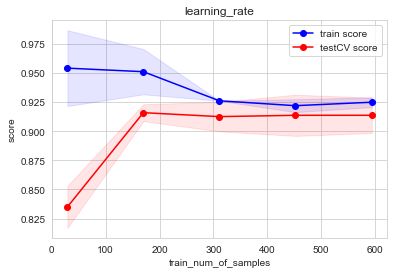

In [47]:
#查看是否過擬合  
def plot_learning_curve(clf, title, X, y, ylim=None, cv=None, n_jobs=3, train_sizes=np.linspace(.05, 1., 5)):
    train_sizes, train_scores, test_scores = learning_curve(clf, X, y, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    ax = plt.figure().add_subplot(111)
    ax.set_title(title)
#ylim是y 座標軸範圍  
#    if ylim is not None:
#    ax.ylim(*ylim)
    ax.set_xlabel(u"train_num_of_samples")
    ax.set_ylabel(u"score")
    ax.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="b")
    ax.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="r")
    ax.plot(train_sizes, train_scores_mean, 'o-', color="b", label=u"train score")
    ax.plot(train_sizes, test_scores_mean, 'o-', color="r", label=u"testCV score")
    ax.legend(loc="best")

    midpoint = ((train_scores_mean[-1] + train_scores_std[-1]) + (test_scores_mean[-1] - test_scores_std[-1])) / 2
    diff = (train_scores_mean[-1] + train_scores_std[-1]) - (test_scores_mean[-1] - test_scores_std[-1])
    return midpoint, diff

plot_learning_curve(grd, u"learning_rate", X_train, y)


In [48]:
# Using the random grid to search for best hyperparameters
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

# Creating the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 5 fold cross validation, 
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 5, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y)
print(rf_random.best_params_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   23.8s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  4.4min finished


{'n_estimators': 600, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 40, 'bootstrap': False}


In [58]:
X_train.head()

,Age,Cabin,Embarked,Family,Fare,Pclass,Sex
0,22.0,6,2,1,-0.503291,3,1
1,38.0,2,0,1,0.734744,1,0
2,26.0,2,2,0,-0.490240,3,0
3,35.0,2,2,1,0.383183,1,0
4,35.0,6,2,0,-0.487824,3,1


## 5.產生csv上傳

In [49]:
gender_submission = pd.DataFrame({'PassengerId':y_test,'Survived':grd.predict(y_train)})
gender_submission.to_csv('submission.csv', index=None)

＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝ 回顧＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝   
[查看資料]  
1.可以發現測試資料及少了要預測目標survival  
[分析資料]  
2.知道哪些欄位有多少缺失值與資料型態  
[特徵工程]  
3.把訓練資料集預測目標移去然後合併資料集一起  
4.性別與生存關係  

fit時訓練與測試集數目要一樣，但在那之前分析樹續量越多越好  

## 6.參考資料  
https://www.kaggle.com/anaskad/step-by-step-solving-titanic-problem
https://chtseng.wordpress.com/2017/12/24/kaggle-titanic%E5%80%96%E5%AD%98%E9%A0%90%E6%B8%AC-1/
https://www.kaggle.com/anaskad/step-by-step-solving-titanic-problem    
https://zhuanlan.zhihu.com/p/27550334  

